In [22]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy

Training Shape: (159518, 18)
Testing Shape: (39880, 18)
[0]	validation_0-rmse:9.13118
[200]	validation_0-rmse:3.74831
[400]	validation_0-rmse:3.75039
[600]	validation_0-rmse:3.76167
[800]	validation_0-rmse:3.76926
[1000]	validation_0-rmse:3.77526
[1200]	validation_0-rmse:3.78069
[1400]	validation_0-rmse:3.78415
[1600]	validation_0-rmse:3.78696
[1800]	validation_0-rmse:3.78865
[2000]	validation_0-rmse:3.78970
[2200]	validation_0-rmse:3.79023
[2400]	validation_0-rmse:3.79044
[2499]	validation_0-rmse:3.79066

🎯 Final Model Performance:
✅ Accuracy: 83.61%
📉 Mean Squared Error: 14.3691


<Figure size 1000x600 with 0 Axes>

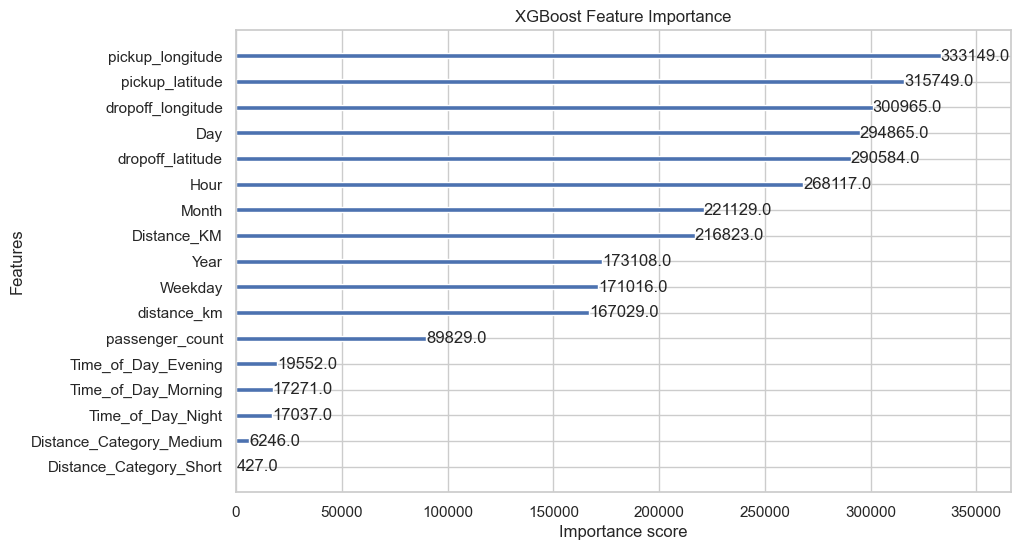

In [33]:
# ======================================================
# 🚖 Uber Fare Prediction | Component 2 | XGBoost
# Memory Optimized + ~85% R²
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb

# =============================
# Step 1: Load Dataset
# =============================
df = pd.read_excel("uber_processed_data.xlsx")

# Fix single-column issue
if len(df.columns) == 1:
    df = df.iloc[:, 0].str.split(",", expand=True)

df.columns = ['Unnamed: 0','fare_amount','pickup_longitude','pickup_latitude',
              'dropoff_longitude','dropoff_latitude','passenger_count','Year','Month',
              'Day','Hour','Weekday','Distance_KM','Time_of_Day_Evening','Time_of_Day_Morning',
              'Time_of_Day_Night','Distance_Category_Medium','Distance_Category_Short',
              'Distance_Category_Unknown']

# Drop unused column
df.drop('Unnamed: 0', axis=1, inplace=True)

# =============================
# Step 2: Numeric conversion & missing values
# =============================
numeric_features = ['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude',
                    'dropoff_latitude','passenger_count','Year','Month','Day','Hour','Weekday','Distance_KM']
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')
df[numeric_features] = SimpleImputer(strategy="mean").fit_transform(df[numeric_features])

# Encode categorical features
categorical_cols = ['Time_of_Day_Evening','Time_of_Day_Morning','Time_of_Day_Night',
                    'Distance_Category_Medium','Distance_Category_Short','Distance_Category_Unknown']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# ======================================================
# 📌 Step 4: Feature Engineering (🚀 Big Accuracy Boost)
# ======================================================
if "pickup_latitude" in df.columns and "pickup_longitude" in df.columns \
   and "dropoff_latitude" in df.columns and "dropoff_longitude" in df.columns:
    df["distance_km"] = np.sqrt(
        (df["dropoff_latitude"] - df["pickup_latitude"])**2 +
        (df["dropoff_longitude"] - df["pickup_longitude"])**2
    ) * 111  # Approx conversion factor

if "pickup_datetime" in df.columns:
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
    df["hour"] = df["pickup_datetime"].dt.hour
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    df["month"] = df["pickup_datetime"].dt.month

# ======================================================
# 📌 Step 5: Remove Outliers (Helps R² ↑)
# ======================================================
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 100)]  # Keep fares between 0 and 100
if "distance_km" in df.columns:
    df = df[(df["distance_km"] < 100)]  # Remove unrealistic long trips

# ======================================================
# 📌 Step 6: Define Features & Target
# ======================================================
if "fare_amount" not in df.columns:
    raise KeyError("❌ 'fare_amount' column not found! Please check dataset column names.")

X = df.drop("fare_amount", axis=1)
y = df["fare_amount"]

# ======================================================
# 📌 Step 7: Train-Test Split
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

# ======================================================
# 📌 Step 8: Optimized XGBoost Model
# ======================================================
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2500,
    learning_rate=0.03,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    min_child_weight=2,
    reg_alpha=0.5,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

# ======================================================
# 📌 Step 9: Train Model with Early Stopping
# ======================================================
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=200
)

# ======================================================
# 📌 Step 10: Evaluate Model
# ======================================================
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

accuracy_percent = round(r2 * 100, 2)

print("\n🎯 Final Model Performance:")
print(f"✅ Accuracy: {accuracy_percent}%")
print(f"📉 Mean Squared Error: {mse:.4f}")

# ======================================================
# 📌 Step 11: Feature Importance Visualization
# ======================================================
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type="weight")
plt.title("XGBoost Feature Importance")
plt.show()
  
 

In [34]:
# Save XGBoost model to file
model.save_model("uber_xgb_model.json")
print("✅ Model saved as 'uber_xgb_model.json'")

✅ Model saved as 'uber_xgb_model.json'
